# Allstate Kaggle competition  
**Late 2016**  
**Enrique Herreros**  
**MSc Data Science University of Amsterdam**  

URL: https://www.kaggle.com/c/allstate-claims-severity  
Contest description:  
*Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience.*

Data description:  
*Each row in this dataset represents an insurance claim. You must predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous. Test, train datasets included, also an example of submission file.*

This notebook covers:
- Data loading
- Data munging (cleaning)
- ML Modelling (GBR + parameter tunning) <- working on this

In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import zipfile
import os
import glob
from math import log
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import time
import scipy
from sklearn.externals import joblib # create pickles for models, avoid retrains
import operator
from sklearn import linear_model
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix # classification evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score # regression evaluation

# setup visual output configs
sns.set_style('darkgrid')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 200
pd.set_option('display.width', 1000)
#import warnings
#warnings.filterwarnings('ignore')

Extract all zips in the folder data sets

In [2]:
for root, dirs, files in os.walk("../data", topdown=False):
    zip_files = glob.glob(root + '/*.zip')
    print("Unzipping...")
    print(zip_files)
    for zip_filename in zip_files:
        dir_name = os.path.splitext(zip_filename)[0]
        zip_handler = zipfile.ZipFile(zip_filename, "r")
        zip_handler.extractall(root)

Unzipping...
['../data\\sample_submission.csv.zip', '../data\\test.csv.zip', '../data\\train.csv.zip']


Load the data into DataFrames

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Explore

What split train/test do we have?

In [3]:
print("{}% of the data is dedicated to train the final model".format((100*train.shape[0])/(train.shape[0] + test.shape[0])))
print(train.shape, test.shape)

59% of the data is dedicated to train the final model
((188318, 132), (125546, 131))


What type of data is there in the columns?

In [4]:
print(zip(train.columns.ravel(),train.dtypes.ravel()))

[('id', dtype('int64')), ('cat1', dtype('O')), ('cat2', dtype('O')), ('cat3', dtype('O')), ('cat4', dtype('O')), ('cat5', dtype('O')), ('cat6', dtype('O')), ('cat7', dtype('O')), ('cat8', dtype('O')), ('cat9', dtype('O')), ('cat10', dtype('O')), ('cat11', dtype('O')), ('cat12', dtype('O')), ('cat13', dtype('O')), ('cat14', dtype('O')), ('cat15', dtype('O')), ('cat16', dtype('O')), ('cat17', dtype('O')), ('cat18', dtype('O')), ('cat19', dtype('O')), ('cat20', dtype('O')), ('cat21', dtype('O')), ('cat22', dtype('O')), ('cat23', dtype('O')), ('cat24', dtype('O')), ('cat25', dtype('O')), ('cat26', dtype('O')), ('cat27', dtype('O')), ('cat28', dtype('O')), ('cat29', dtype('O')), ('cat30', dtype('O')), ('cat31', dtype('O')), ('cat32', dtype('O')), ('cat33', dtype('O')), ('cat34', dtype('O')), ('cat35', dtype('O')), ('cat36', dtype('O')), ('cat37', dtype('O')), ('cat38', dtype('O')), ('cat39', dtype('O')), ('cat40', dtype('O')), ('cat41', dtype('O')), ('cat42', dtype('O')), ('cat43', dtype('O

Neither the contest details nor the name of the columns gives us information about the data on hands, we need to investigate more...

In [5]:
train.shape

(188318, 132)

Let's observe 3 random samples of the data (one image is worth a thousand words)

In [6]:
train.sample(3)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
148845,464139,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,B,A,C,B,D,B,A,A,A,C,A,D,B,C,E,E,D,T,I,C,A,A,D,E,J,K,K,BI,EL,C,E,AE,A,P,CR,0.316554,0.127059,0.613660,0.292430,0.422268,0.355523,0.370534,0.31796,0.32311,0.30529,0.263154,0.258859,0.598688,0.797940,630.72
38240,119871,A,B,A,B,A,A,A,A,B,B,B,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,D,B,B,D,D,B,B,A,B,B,B,A,A,A,G,H,D,D,D,E,C,A,P,I,M,A,A,D,F,H,G,B,BI,CL,C,F,BN,A,K,EC,0.461344,0.488789,0.944251,0.432728,0.902259,0.385129,0.459526,0.38318,0.39046,0.45017,0.453334,0.443374,0.342239,0.782291,200.00
86790,271731,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,E,A,P,N,A,A,A,D,E,J,H,B,BI,EG,E,N,BM,A,L,CK,0.330514,0.737068,0.613660,0.473202,0.908217,0.240069,0.283691,0.24564,0.30859,0.32446,0.223038,0.220003,0.333292,0.604140,1617.46


Hos does the loss look like?

In [7]:
print(train["loss"].quantile(.99))
train["loss"].describe()
# 99% of the data has a loss under ~14.000€. Maybe a good idea is to later train the model only using this threshold?

13981.203


count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

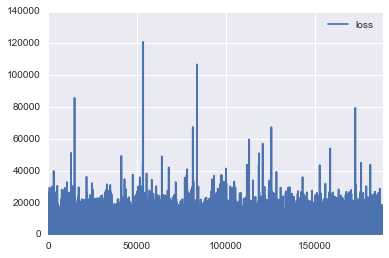

In [9]:
train.plot(y="loss")

(0, 8000)

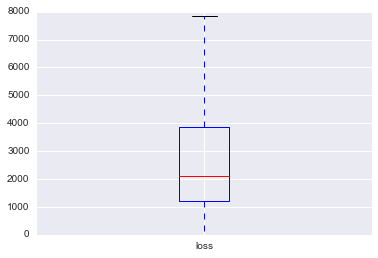

In [31]:
ax1 = train.boxplot(column="loss", return_type='axes')
ax1.set_ylim([0, 8000])

And yet another way of looking it at it

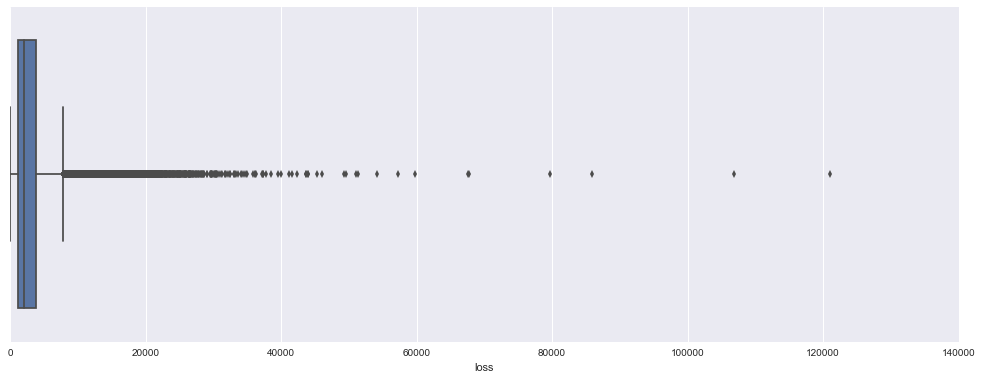

In [29]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
sns.boxplot(train["loss"])

(0, 25000)

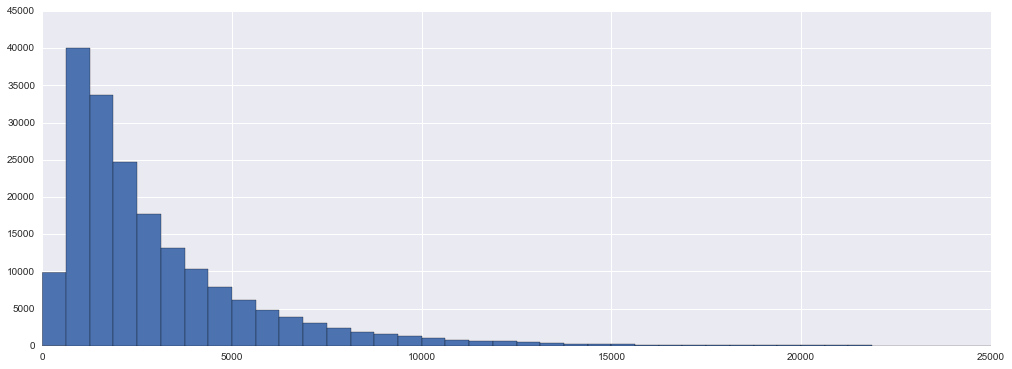

In [33]:
fig, ax = plt.subplots()
ax.hist(train[train["loss"] < 25000].loss, bins=40)
ax.set_xlim([0, 25000])

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.10000000e+01,   1.90000000e+01,   1.20000000e+01,
          2.30000000e+01,   3.20000000e+01,   4.30000000e+01,
          8.60000000e+01,   1.47000000e+02,   2.79000000e+02,
          5.70000000e+02,   1.02700000e+03,   1.62200000e+03,
          3.65900000e+03,   5.89500000e+03,   8.47400000e+03,
          1.03940000e+04,   1.18470000e+04,   1.32230000e+04,
          1.43820000e+04,   1.48540000e+04,   1.49530000e+04,
          1.41670000e+04,   1.33440000e+04,   1.21920000e+04,
          1.11450000e+04,   9.68400000e+03,   7.89900000e+03,
        

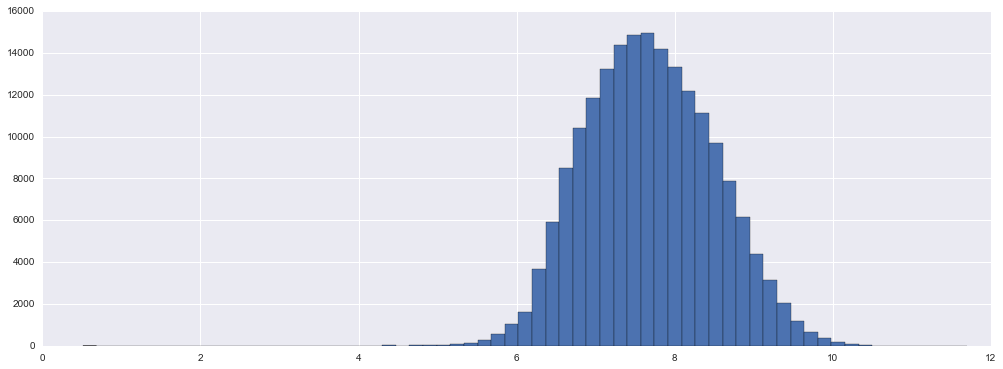

In [31]:
fig.set_size_inches(17.5, 8.5)
fig, ax = plt.subplots(1, 1)
ax.hist(np.log1p(train["loss"]), bins=65)

Nice, this looks just like a Normal distribution, good sign; we don't need to remove outliers :)

In [3]:
train["loss"] = np.log1p(train["loss"])

Transform categorical values into dummy values.  
*Example: 1: a b c ->1_a : 1 0 0, 1_b : 0 1 0, 1_c : 0 0 1*

In [4]:
train_dummies = pd.get_dummies(train) # this already removes the original categorical variables
train_dummies.shape

(188318, 1155)

Let's look at the boxplot of every 

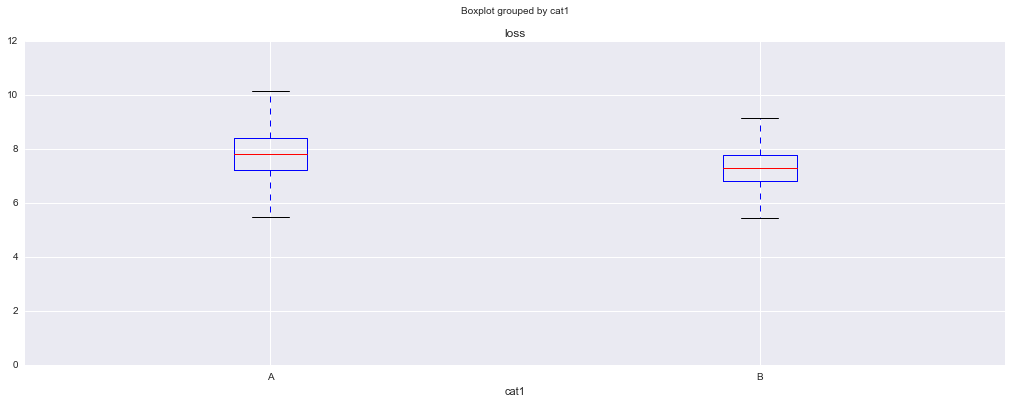

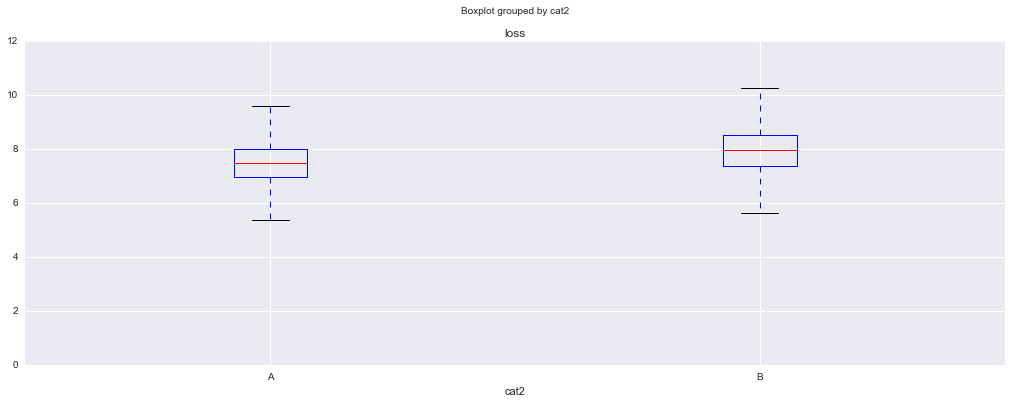

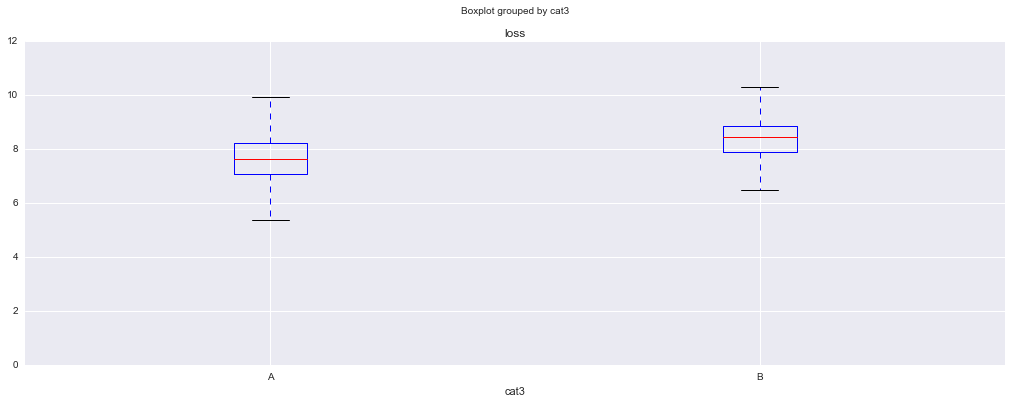

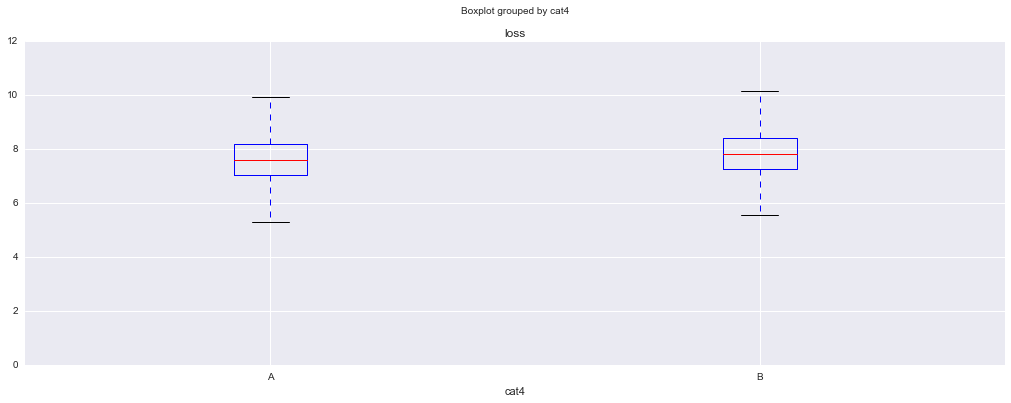

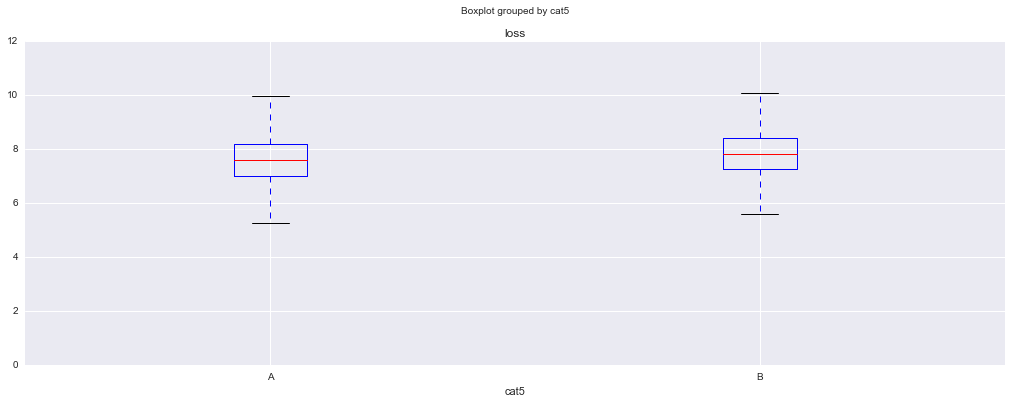

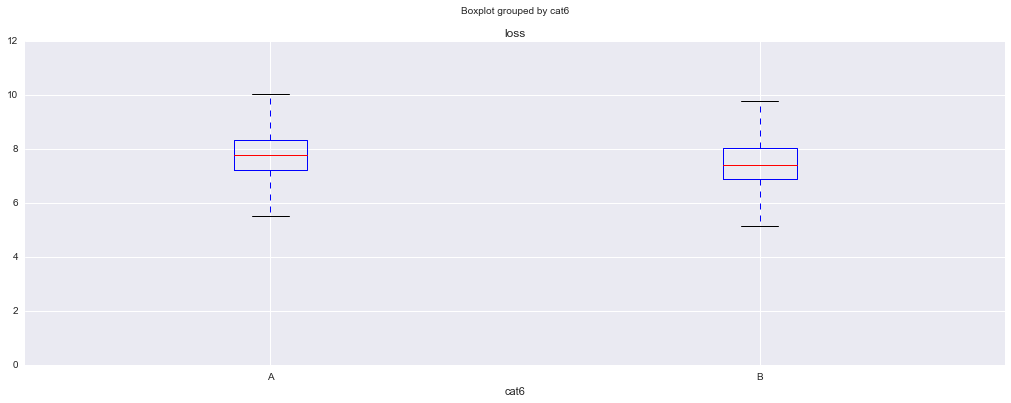

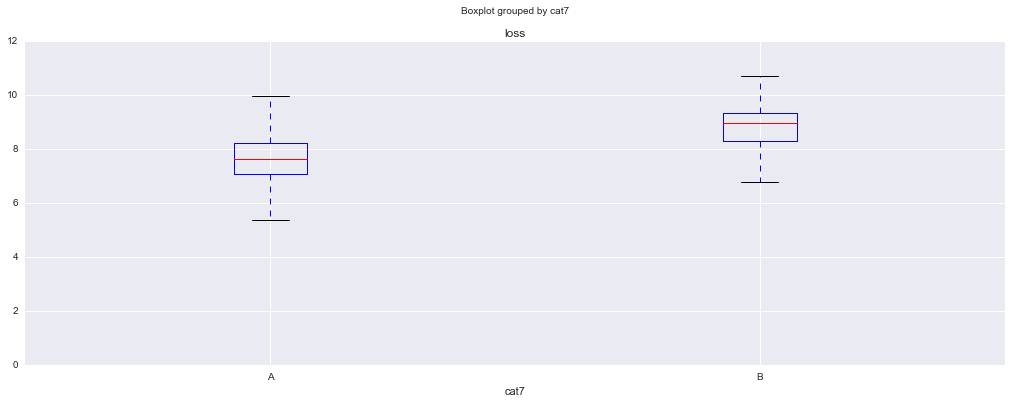

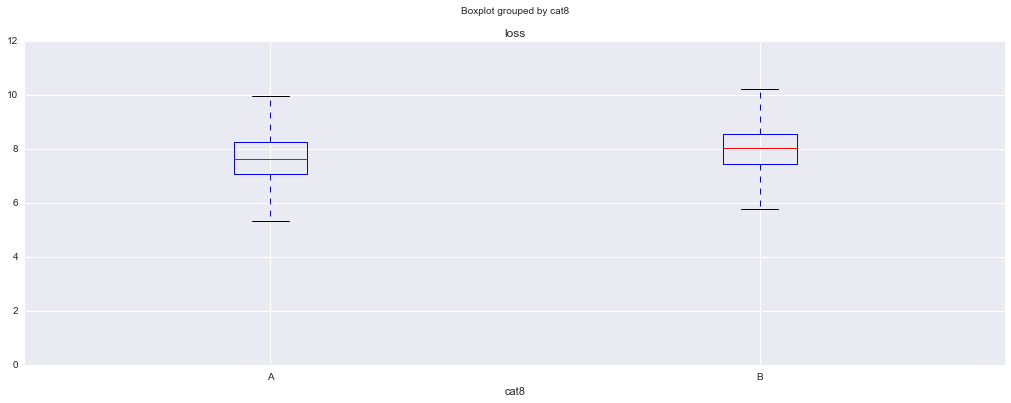

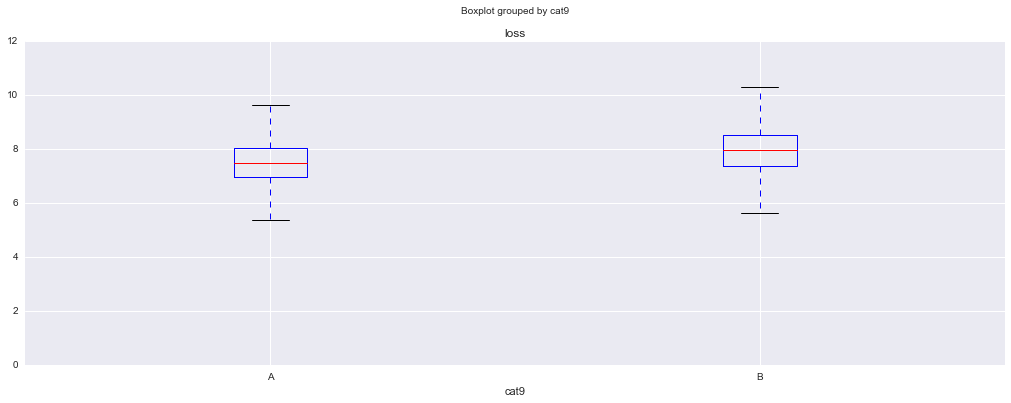

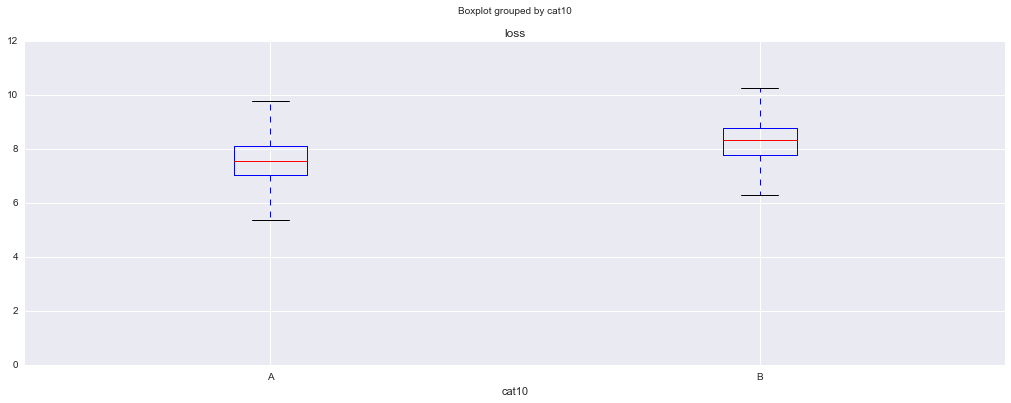

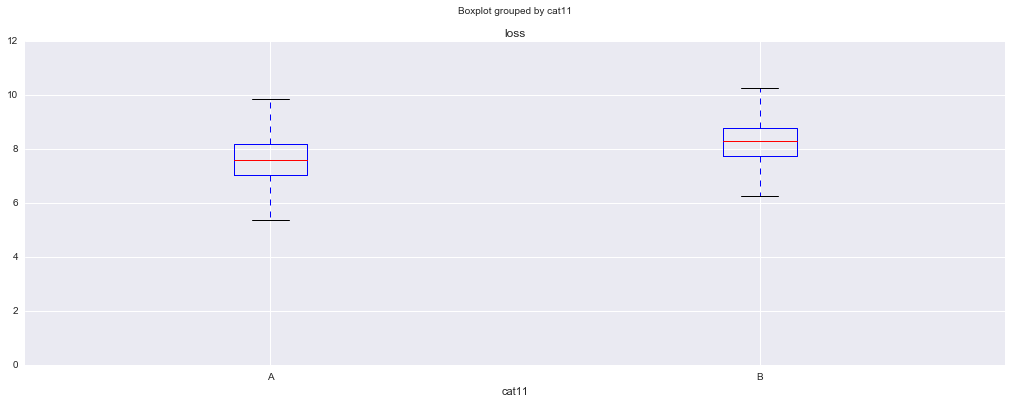

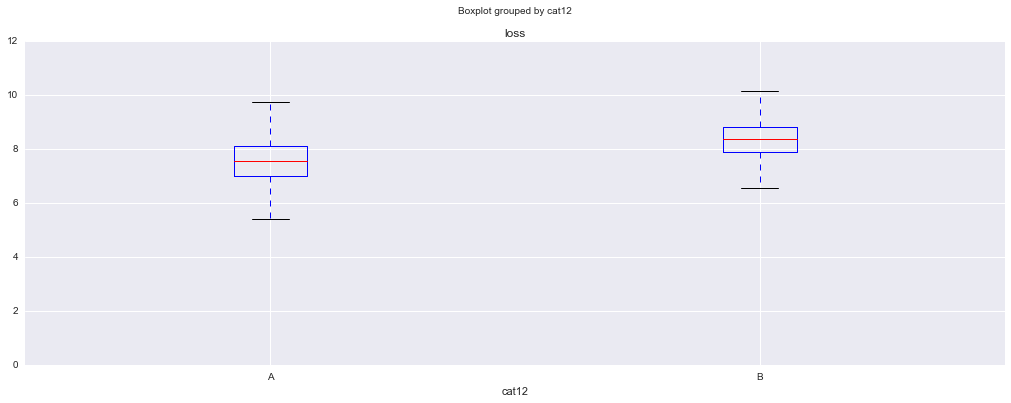

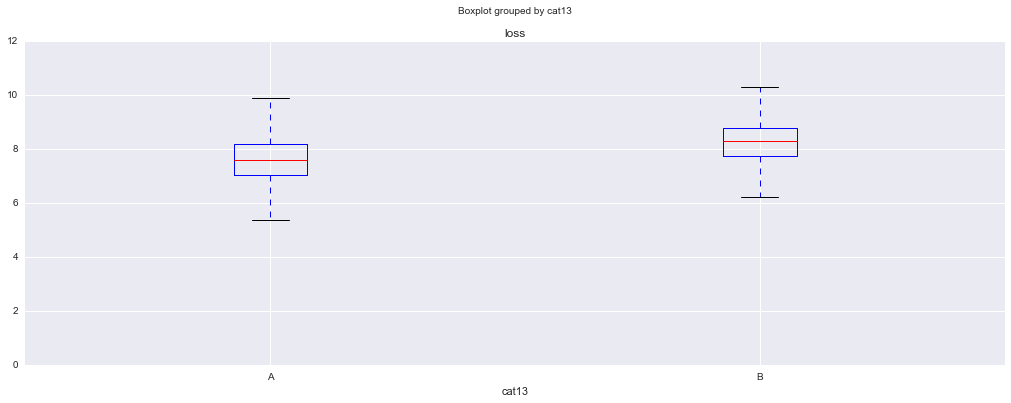

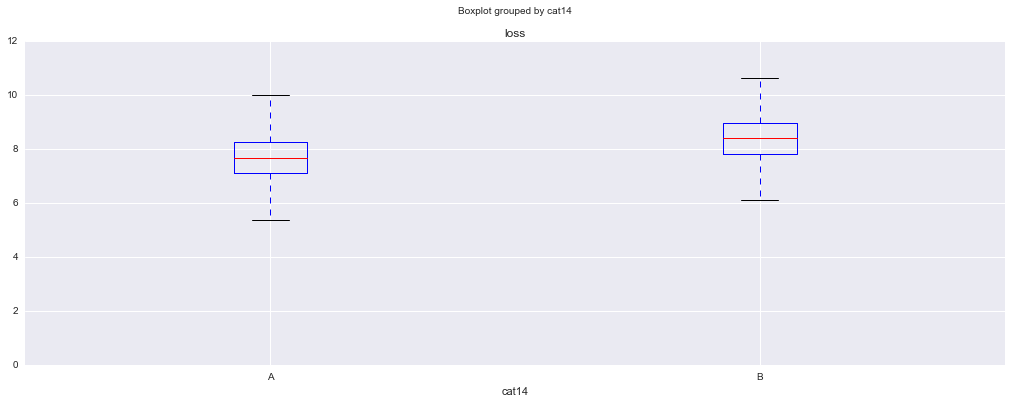

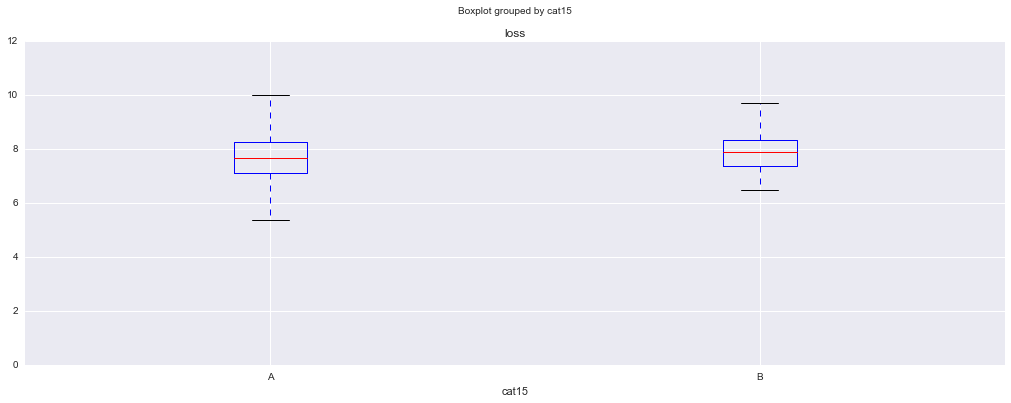

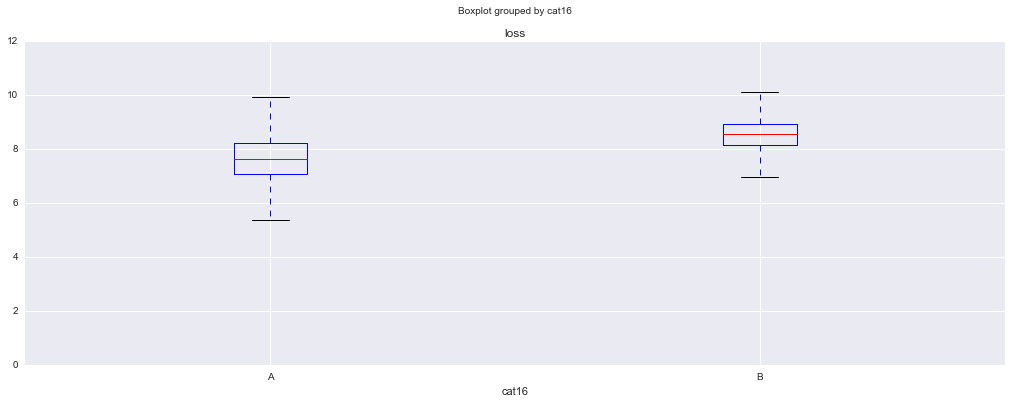

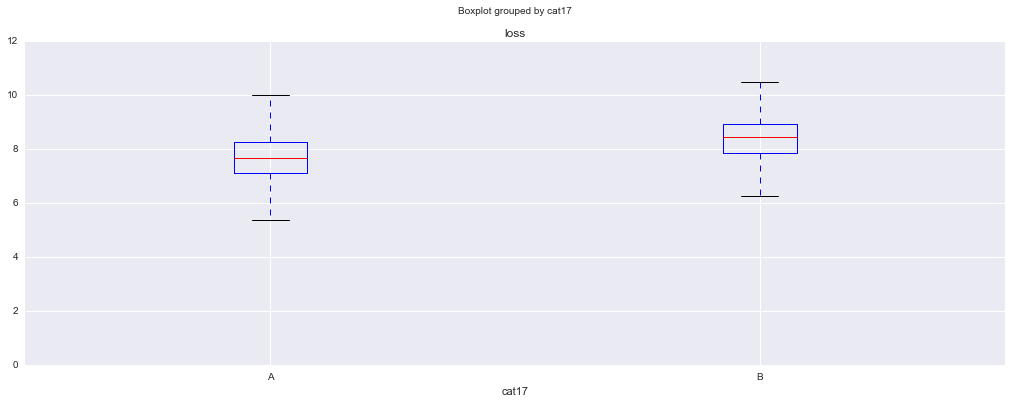

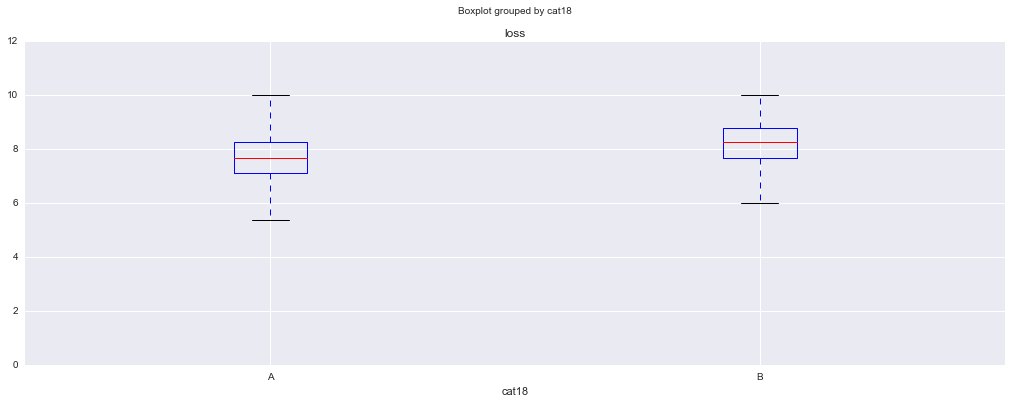

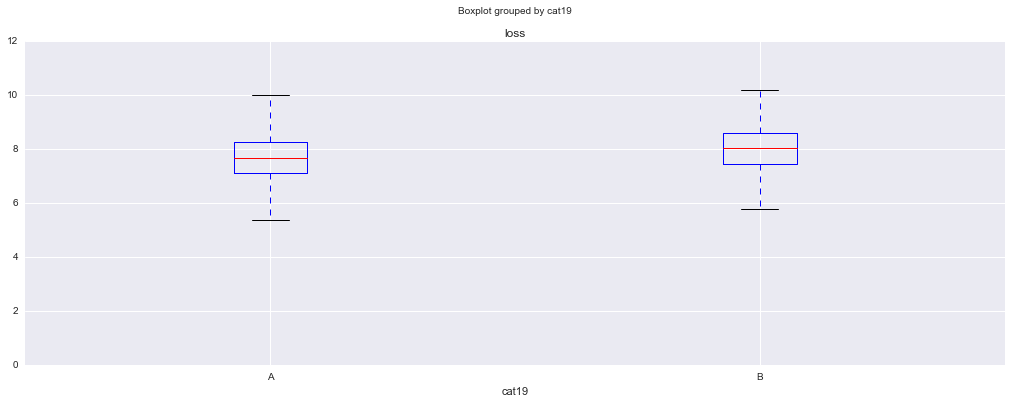

In [39]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx < 20 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        #ax1.set_ylim([0, 20000])

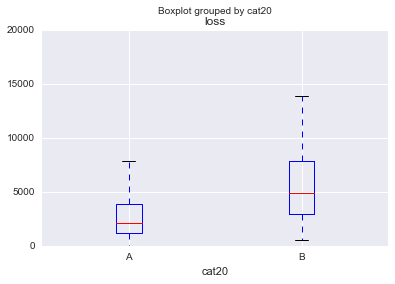

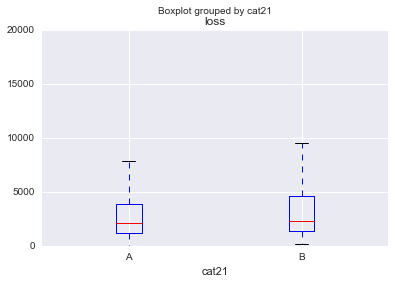

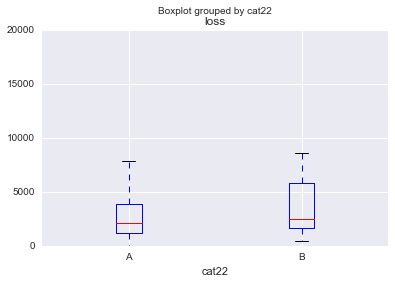

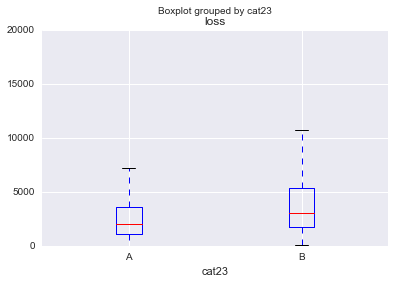

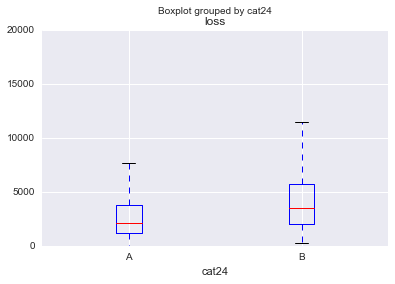

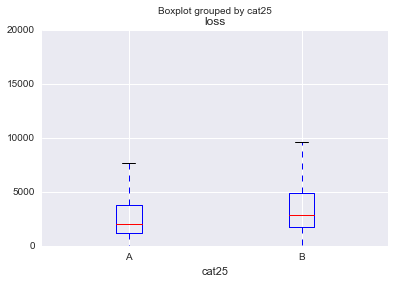

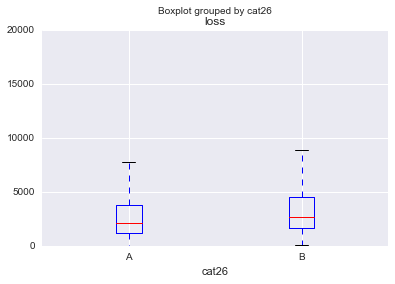

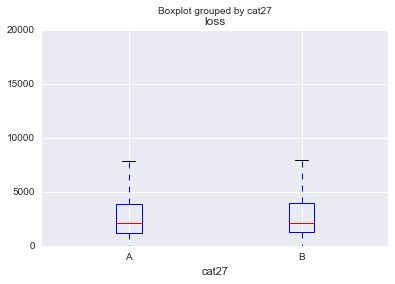

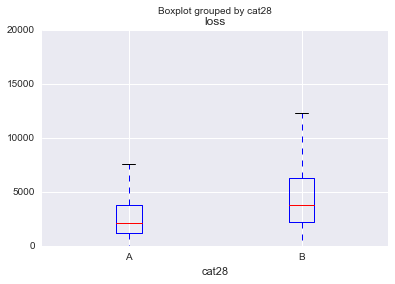

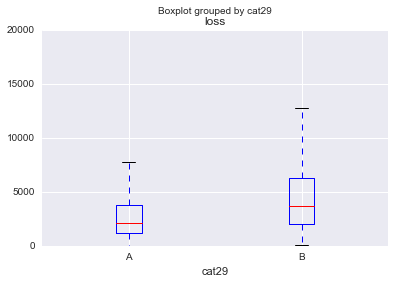

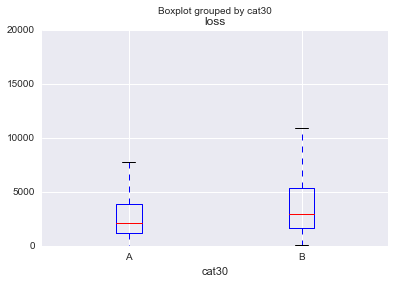

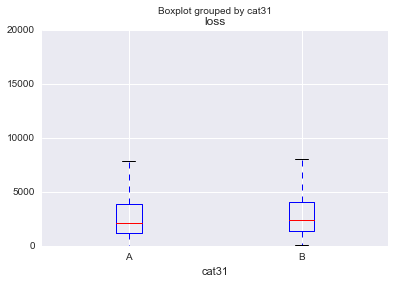

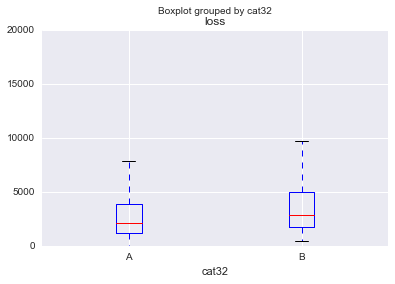

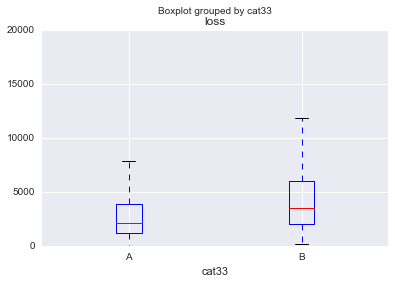

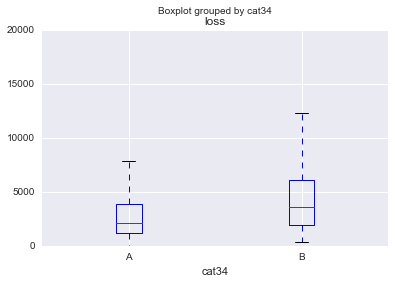

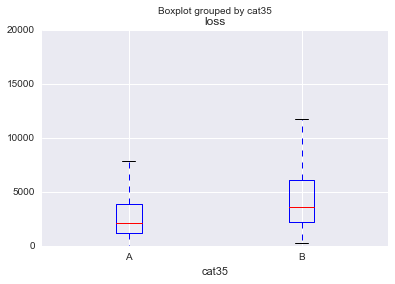

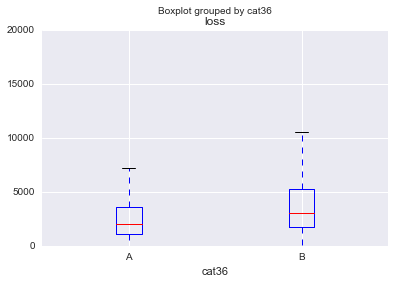

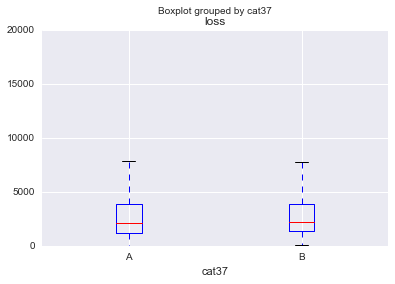

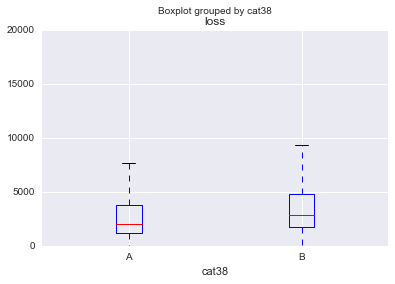

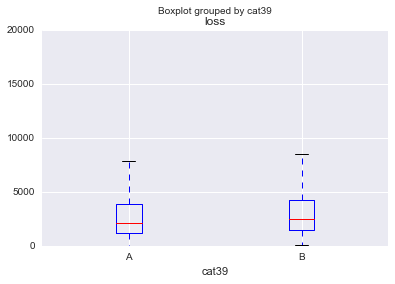

In [28]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx >= 20 and idx < 40 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        ax1.set_ylim([0, 20000])

In [ ]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx >= 40 and idx < 60 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        ax1.set_ylim([0, 20000])

In [ ]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx >= 60 and idx < 80 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        ax1.set_ylim([0, 20000])

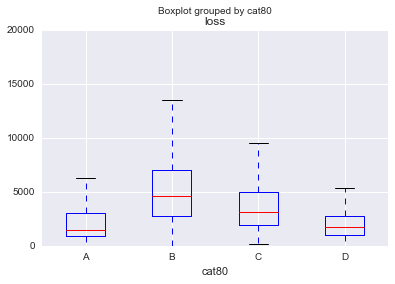

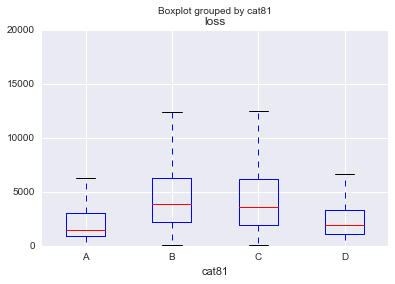

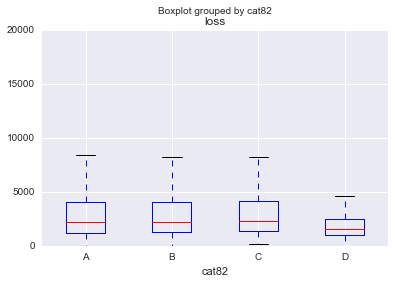

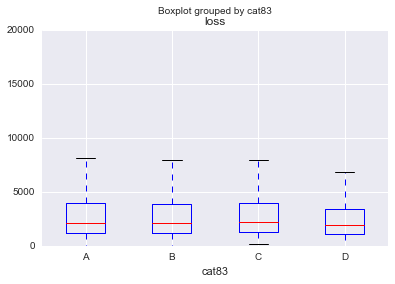

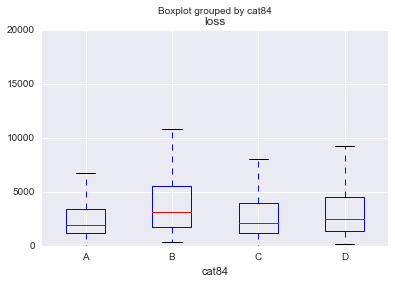

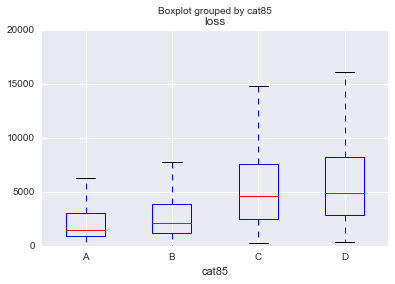

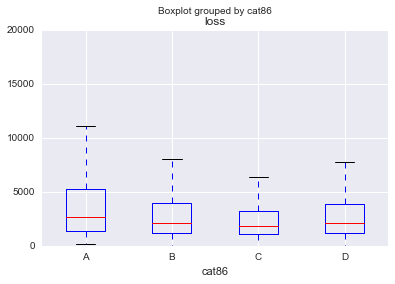

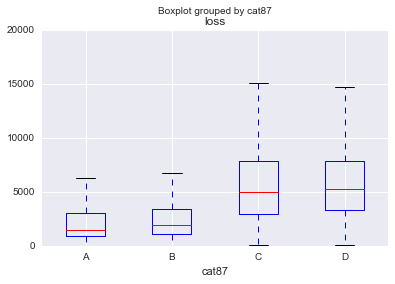

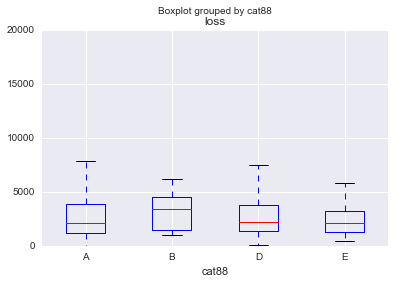

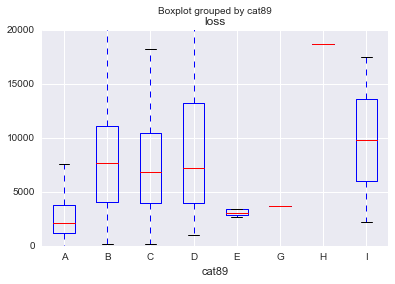

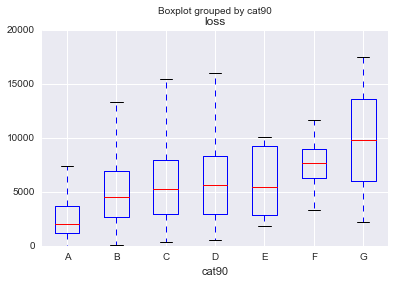

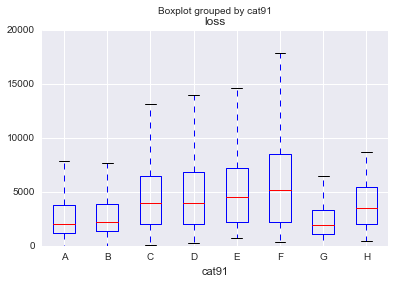

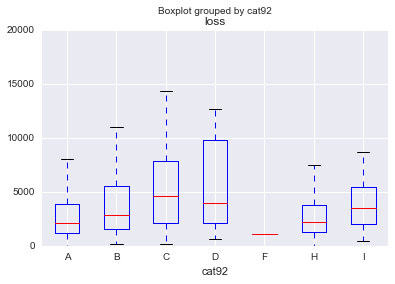

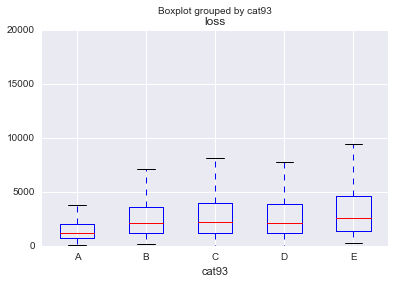

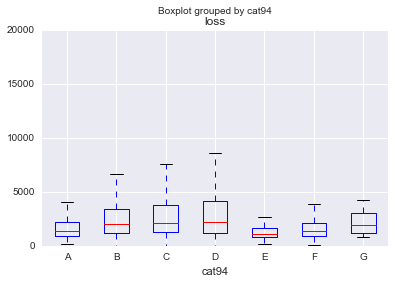

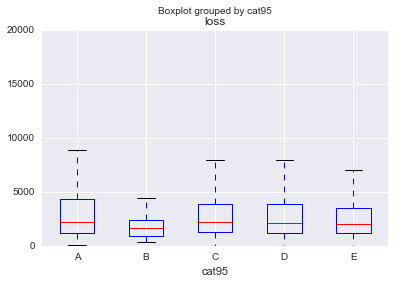

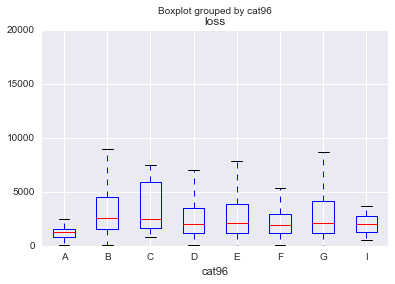

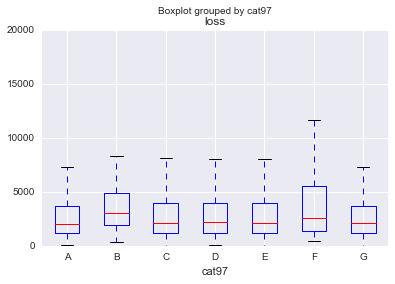

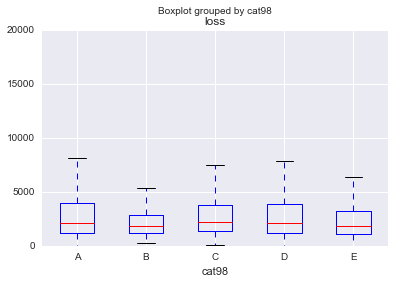

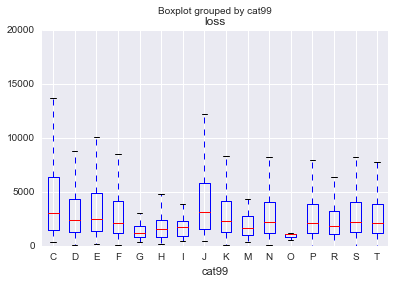

In [62]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx >= 80 and idx < 100 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        ax1.set_ylim([0, 20000])

In [ ]:
for idx, cat_value in enumerate(train.columns.ravel()):
    if idx >= 100 and str(cat_value).startswith("cat"):
        ax1 = train.boxplot(column="loss",by=cat_value)
        #ax1.set_ylim([0, 20000])

### Numerical values

There are continuous variables and categorical variables. Let's investigate both kinds of data

In [9]:
filter_col = [col for col in list(train) if col.startswith('cont')]
train[filter_col].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


**What is the distribution of the 14 continuous variables?**

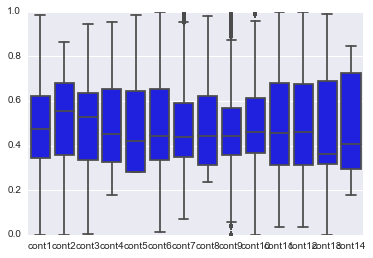

In [25]:
sns.boxplot(train[filter_col], color="blue")

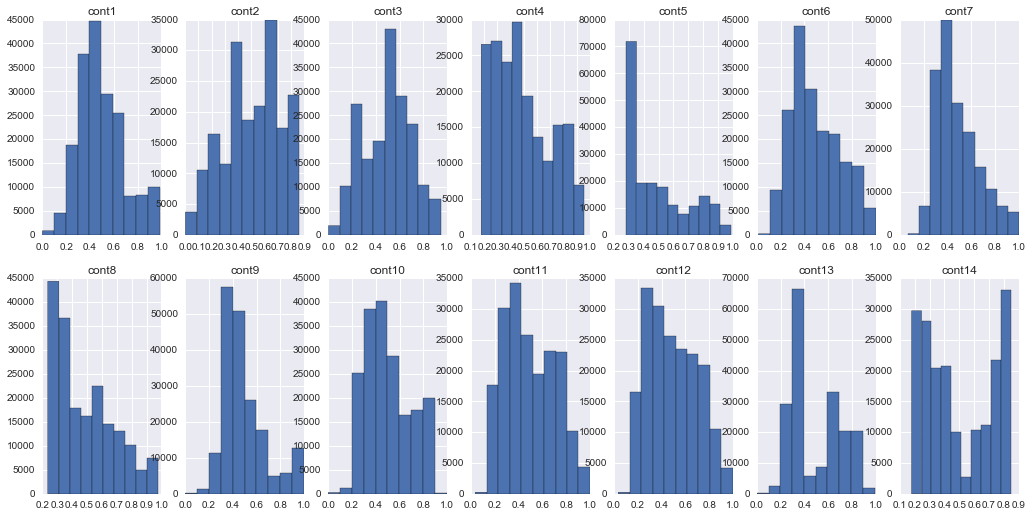

In [44]:
fig, axarr = plt.subplots(2, 7)
for i in range(0,14):
    axarr[i/7,i%7].hist(train["cont" + str(i+1)])
    axarr[i/7,i%7].set_title("cont" + str(i+1))
fig.set_size_inches(17.5, 8.5)

We should consider normalizing skewed variables such as cont13 or cont14

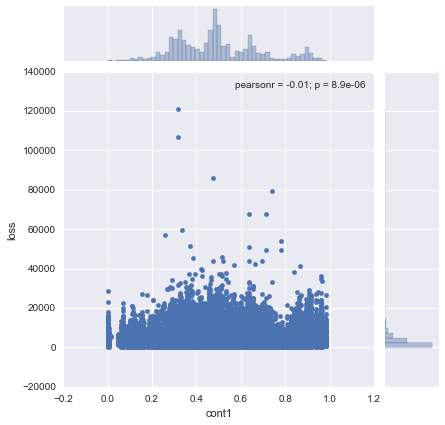

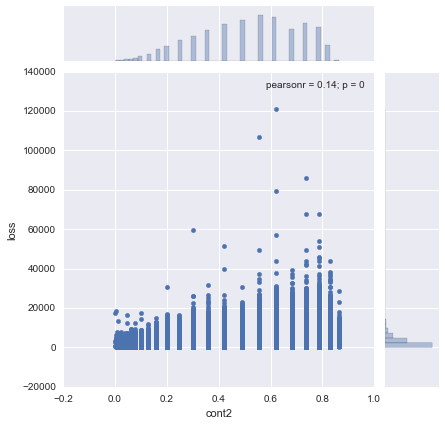

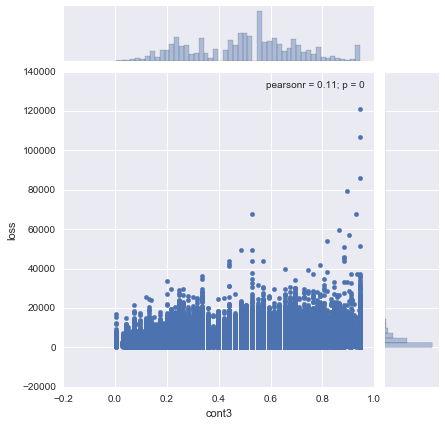

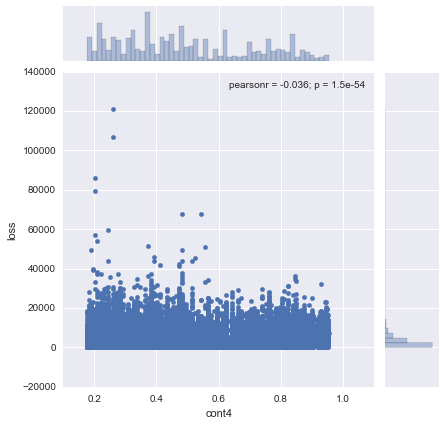

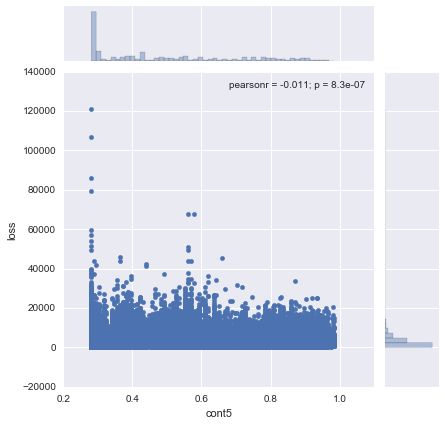

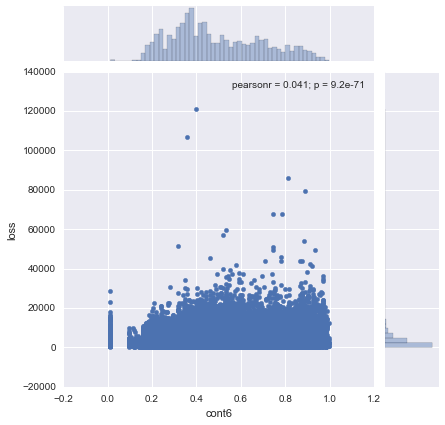

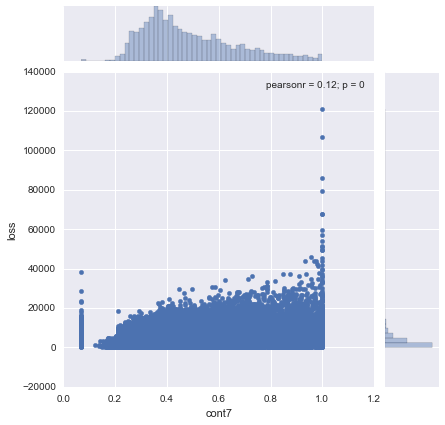

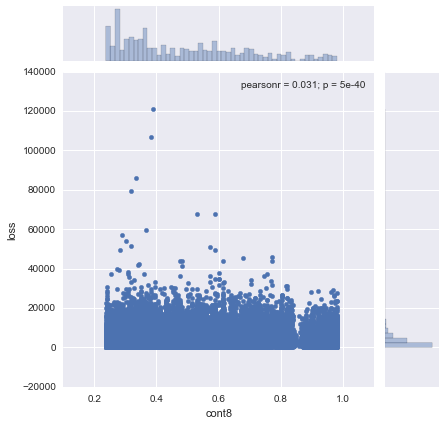

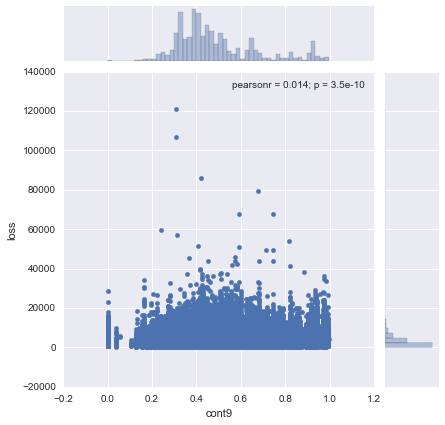

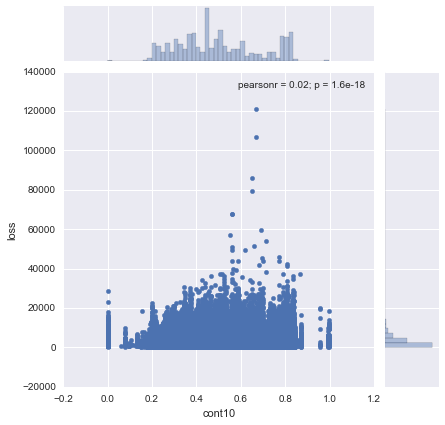

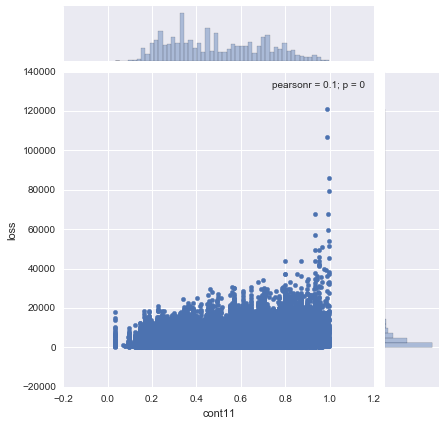

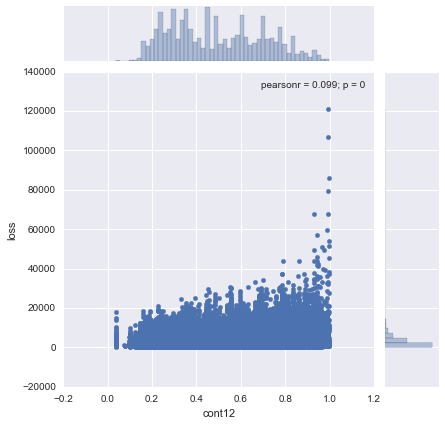

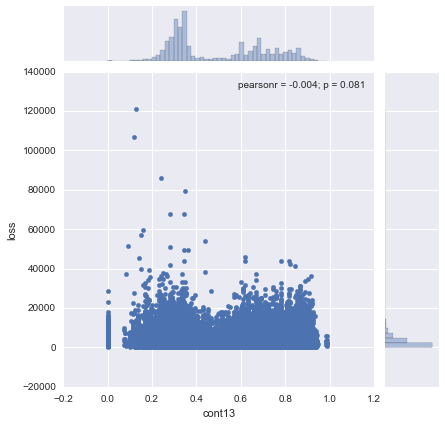

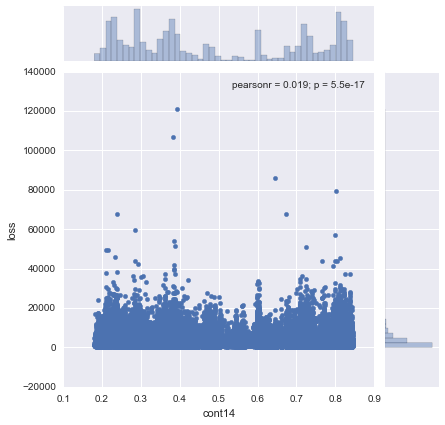

In [51]:
for i in range(0,14):
    sns.jointplot(train["cont" + str(i+1)], train["loss"])
    
# Way faster than:
#g = sns.PairGrid(train.iloc[0:200,, y_vars=["loss"], x_vars=filter_col[:3], size=5)
#g.map(sns.regplot, color=".3")
#g.set(ylim=(-1, 140000))

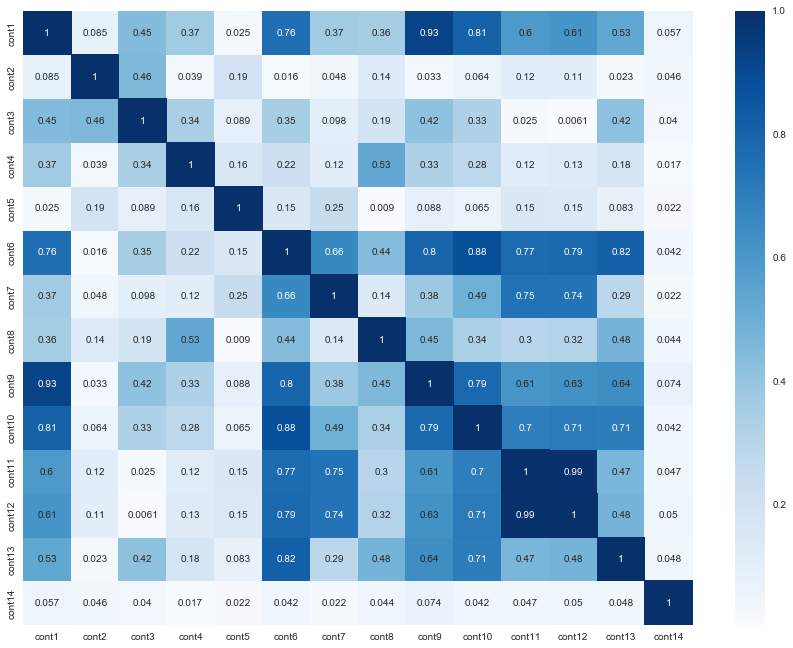

In [60]:
correlationMatrix = train[filter_col].corr().abs()

plt.subplots(figsize=(15, 11))
sns.heatmap(correlationMatrix,annot=True, cmap="Blues")

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False, cmap="Blues")



### ML modelling

In [4]:
# Function for model evaluation
def eval_model(df, column_names, gbr_est_param):
    train, test = train_test_split(df[column_names], train_size = 0.5)
    #train.set_index("instaGramId", inplace=True)
    #test.set_index("instaGramId", inplace=True)
    if "id" in column_names:
        column_names.remove("id")
    X_train = train.drop("loss", 1)
    y_train = train["loss"]
    X_test = test.drop("loss", 1)
    y_test = test["loss"]
    start = time.time()
    if "id" in column_names:
        est = gbr_est_param.fit(X_train.drop("id", 1), y_train)
    else:
        est = gbr_est_param.fit(X_train, y_train)
    print("Fitting of the model took", str(float(time.time() - start)), "seconds")
    if type(gbr_est_param) == GradientBoostingRegressor:
        feature_importances_dict = {train_column_name: feature_importance for (train_column_name,
                                                                               feature_importance) in zip(column_names, est.feature_importances_)}
        top10_feature_importances = sorted(feature_importances_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]
        print("Distribution of importances of variables, sum is 1:")
        print(top10_feature_importances)
    y_pred = est.predict(X_test.drop("id", 1))
    print("Mean absolute error is: %.2f\t" % mean_absolute_error(y_test, y_pred))
    print("Mean squared error is: %.2f\t" % mean_squared_error(y_test, y_pred))
    print("Median absolute error is: %.2f\t" % median_absolute_error(y_test, y_pred))
    print("R^2 score:\t%.4f\t" % r2_score(y_test, y_pred))
    print(zip(list(y_test.iloc[0:15]), list(y_pred[0:15])))
    # linear only, does NOT assume that both datasets are normally distributed.
    print("Pearson correlation (correlation, p-value):", scipy.stats.spearmanr(y_test, y_pred))
    # linear only, does assume that both datasets are normally distributed.
    print("Spearman rank-order (correlation, p-value):", scipy.stats.pearsonr(y_test, y_pred))
    return est

# Format the submission and save it into a csv
def create_submission(id, loss):
    submission = pd.DataFrame({
        "id": id,
        "loss": loss
        })

    submission.to_csv('../submissions/output_' + str(time.time()) + '.csv', index=False)

**First try, GBR + hyperparameter tunning on numerical values (originally continuous + dummies)**

In [7]:
filter_col_num = [col for col in list(train) if col.startswith('cont') or col == "loss"]

In [ ]:
tuned_parameters1 = [{#'n_estimators': [200, 100, 50, 20],
                      #'max_depth': [2, 4, 6],
                      'criterion': ["mae"],
                      #'learning_rate': [1e-1, 1e-2]
    },
                   ]
grid1 = GridSearchCV(estimator=GradientBoostingRegressor(verbose=True), param_grid=tuned_parameters1)
grid1 = grid1.fit(train[filter_col_num].drop("loss", 1).iloc[0:10000], train["loss"].iloc[0:10000])
grid1.best_params_ # {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

      Iter       Train Loss   Remaining Time 
         1           0.6541            6.10m
         2           0.6506            6.52m
         3           0.6480            6.59m
         4           0.6452            6.35m
         5           0.6428            6.31m
         6           0.6409            6.29m
         7           0.6391            6.26m
         8           0.6369            6.05m


In [87]:
#train_num.head(2)

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60


In [ ]:
#train_column_names = list(train_dummies.columns.ravel())
est1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2)
model1 = eval_model(train, filter_col_num, grid1.best_estimator_)

      Iter       Train Loss   Remaining Time 


In [11]:
test_id = test.id
test_dummies = pd.get_dummies(test)

# not common dummy features
c = list(set(train_dummies.columns.ravel()).difference(test_dummies.columns.ravel()))
for uniq in c:
    if (uniq in test_dummies) and (uniq not in train_dummies):
        print("{0} is in the test set but not in the train set. Caution, the model hasn't been trained using this feature. Adding... consider retraining".format(str(uniq)))
        #train_dummies[uniq] = 0
    elif (uniq not in test_dummies) and (uniq in train_dummies):
        print("{0} is in the train set but not in the test set. Adding with value 0...".format(str(uniq)))
        test_dummies[uniq] = 0
        #test_dummies[uniq] = 0 # solve before training and retrain model

cat113_BE is in the train set but not in the test set. Adding with value 0...
cat116_CC is in the train set but not in the test set. Adding with value 0...
cat89_I is in the train set but not in the test set. Adding with value 0...
cat110_AN is in the train set but not in the test set. Adding with value 0...
cat110_AF is in the train set but not in the test set. Adding with value 0...
cat116_V is in the train set but not in the test set. Adding with value 0...
cat116_HU is in the train set but not in the test set. Adding with value 0...
cat116_HO is in the train set but not in the test set. Adding with value 0...
loss is in the train set but not in the test set. Adding with value 0...
cat110_BK is in the train set but not in the test set. Adding with value 0...
cat110_BI is in the train set but not in the test set. Adding with value 0...
cat110_BN is in the train set but not in the test set. Adding with value 0...
cat109_BV is in the train set but not in the test set. Adding with value

In [19]:
submission = model1.predict(test_dummies[train_dummies.columns.ravel()].drop(["id","loss"], 1))
create_submission(test_id, submission.reshape(-1))

IOError: [Errno 2] No such file or directory: './submissions/output_1476486950.06.csv'

In [ ]:
init_time = time.time()
tuned_parameters1_2 = [{'criterion' : ["mae"],
                        #'n_estimators': [160, 150, 130, 100],
                        'n_estimators': [100, 50],
                        'max_depth': [2, 3],
                        'learning_rate': [1e-1]},
                   ]
grid1_2 = GridSearchCV(estimator=GradientBoostingRegressor(verbose=True), param_grid=tuned_parameters1_2)
grid1_2 = grid1_2.fit(train_dummies.drop(["loss", "id"], 1), train_dummies["loss"])
grid1_2.best_params_ # {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
print("total time: " + str(init_time - time.time()))

In [ ]:
model1_2 = grid1_2.best_estimator_
submission = model1_2.predict(test_dummies[train_dummies.columns.ravel()].drop(["id","loss"], 1))
create_submission(test_id, submission.reshape(-1))

In [ ]:
init_time = time.time()
rf1 = RandomForestRegressor(criterion="mae", n_estimators=150, n_jobs=1, min_samples_leaf = 4,
                            compute_importances = True, random_state=7354)
rf1.fit(train_dummies.drop(["loss", "id"], 1), train_dummies["loss"])
submission_rf1 = rf1.predict(test_dummies[train_dummies.columns.ravel()].drop(["id","loss"], 1))
create_submission(test_id, submission.reshape(-1))
print("total time: " + str(init_time - time.time()))

In [ ]:
r1 = RandomForestRegressor(criterion="mae", n_estimators=150, n_jobs=1, min_samples_leaf = 4,
                            compute_importances = True, random_state=7354)
eval_model(train_dummies, train_column_names, rf1)

In [ ]:
r2 = RandomForestRegressor(criterion="mae", n_estimators=150, n_jobs=1, min_samples_leaf = 3,
                            compute_importances = True, random_state=7354)
eval_model(train_dummies, train_column_names, rf1)

**3rd try, GBR + dummies on categorical features**

In [ ]:
train_column_names = list(train_dummies.columns.ravel())
est2 = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=2, criterion="mae")
model2 = eval_model(train_dummies, train_column_names, est2)

In [ ]:
test_id = test.id
test_dummies = pd.get_dummies(test)

In [ ]:
# not common dummy features
c = list(set(train_dummies.columns.ravel()).difference(test_dummies.columns.ravel()))
for uniq in c:
    if (uniq in test_dummies) and (uniq not in train_dummies):
        print("{0} is in the test set but not in the train set. Caution, the model hasn't been trained using this feature. Adding... consider retraining".format(str(uniq)))
        train_dummies[uniq] = 0
    elif (uniq not in test_dummies) and (uniq in train_dummies):
        print("{0} is in the train set but not in the test set. Adding with value 0...".format(str(uniq)))
        test_dummies[uniq] = 0
        #test_dummies[uniq] = 0 # solve before training and retrain model

In [ ]:
submission = model2.predict(test_dummies[[train_dummies.columns.ravel()]].drop("id", 1))
create_submission(test_id, submission.reshape(-1))

In [138]:
test_dummies.shape, train_dummies.shape

((125546, 1192), (188318, 1155))

Try with log(loss) as predictor

In [8]:
train_column_names = list(train_dummies.columns.ravel())
estx = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2)
modelx = eval_model(train_dummies, train_column_names, estx)

MemoryError: 

I hope this will be useful for you. Please share your comments/feedback! I want to hear what you think  
More EDA analysis for this competition: (Thanks for the motivation on the analysis part Achal):  
https://www.kaggle.com/achalshah/allstate-claims-severity/allstate-feature-analysis-python/comments